<a href="https://colab.research.google.com/github/ccamila/IA-aplicada-a-Saude/blob/main/TCC_ML_Sistema_circulatorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leitura dos Dados

DBs utilizados: MIMIC IV e MIMIC-IV-ED

Realiza o mount do Google Drive para que possamos usá-lo como um diretório. Neste playbook, utilizaremos os arquivos csv que estão na pasta 'data' do Google Drive pessoal

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Abaixo, fazemos a leitura do csv diagnosis para um Dataframe e exibe os tipos das colunas disponibilizadas

In [2]:
import pandas as pd
import numpy as np

diagnosis_df = pd.read_csv("/content/drive/MyDrive/data/diagnosis.csv")
diagnosis_df.dtypes
# diagnosis_df

subject_id      int64
stay_id         int64
seq_num         int64
icd_code       object
icd_version     int64
icd_title      object
dtype: object

Abaixo, fazemos a leitura do csv patients para um Dataframe e exibe uma amostragem dos dados

In [3]:
patients_df = pd.read_csv("/content/drive/MyDrive/data/patients.csv")
patients_df.dtypes

subject_id            int64
gender               object
anchor_age            int64
anchor_year           int64
anchor_year_group    object
dod                  object
dtype: object

Faz a leitura do csv vitalsign para um Dataframe e imprime os tipos das colunas disponibilizadas

In [4]:
vital_sign_df = pd.read_csv("/content/drive/MyDrive/data/vitalsign.csv")
vital_sign_df.dtypes

subject_id       int64
stay_id          int64
charttime       object
temperature    float64
heartrate      float64
resprate       float64
o2sat          float64
sbp            float64
dbp            float64
rhythm          object
pain            object
dtype: object

In [5]:
patients_df['age'] = patients_df['anchor_age']
patients_df.drop(['anchor_year', 'anchor_year_group', 'dod', 'anchor_age'], axis=1, inplace=True)
# GENDER para inteiro, onde F = 0 e M = 1
patients_df['gender'] = np.where(patients_df['gender'] == 'F', 0, 1)
patients_df.drop(patients_df[patients_df['age'] > 81].index, inplace=True)

In [6]:
# Removemos o icd_title pois apenas aceita colunas númericas.
diagnosis_df = diagnosis_df.drop("icd_title", axis=1)
# Coluna criada com todas as linhas com valor zero (false), caso seja o diagnostico buscado, atribuiremos
# o valor 1 (true)
diagnosis_df['has_disease'] = 0

# Busca pelas Doenças
Começaremos agora a busca pelas doenças do sistema circulatório. \
No **CID 9, são as doenças que tem número de 390 a 459**. No **CID 10, são os códigos que começam com o caractere 'I'**. Como icd_code é uma coluna de strings, usaremos o método 'startswith' para realizar essa busca.

> Esse método aceita uma string ou então uma tupla de strings caso deseje realizar uma busca múltipla.

Além disso, atribuiremos o valor '1' à coluna has_disease para sinalizar que está linha indica o diagnóstico desejado.






In [7]:
disease_codes_tuple = ()
# 390 a 459 são as doenças do sistema circulatório. No range o último número não é incluído
for i in range(390, 460):
  disease_codes_tuple = disease_codes_tuple + (str(i),)
diagnosis_df.loc[(diagnosis_df['icd_code'].str.startswith("I")) & (diagnosis_df['icd_version'] == 10), 'has_disease'] = 1
diagnosis_df.loc[(diagnosis_df['icd_code'].str.startswith("disease_codes_tuple")) & (diagnosis_df['icd_version'] == 9), 'has_disease'] = 1
# Depois de terminar a coluna 'has_disease', removo as colunas
# 'icd_version' e 'icd_code' pois elas não terão mais utilidade
diagnosis_df = diagnosis_df.drop(["icd_version", "icd_code"], axis=1)
diagnosis_df

,subject_id,stay_id,seq_num,has_disease
0,10000032,32952584,1,0
1,10000032,32952584,2,0
2,10000032,32952584,3,0
3,10000032,33258284,1,0
4,10000032,33258284,2,0
...,...,...,...,...
899045,19999828,30712109,1,0
899046,19999828,32917002,1,0
899047,19999828,32917002,2,0
899048,19999914,32002659,1,0


# Ajustes nos DB

Nesse próximo bloco, realizamos um agrupamento com subject_id e stay_id, assim podemos saber com que doenças o paciente foi diagnosticado em uma determinada visita.

In [8]:
# A função lambda verifica se existe o valor '1' na coluna has_disease em cada grupo
# Reset_index foi usada para transformar o GroupbyDataFrame em um DataFrame normal
diagnosis_df = diagnosis_df.groupby(['subject_id', 'stay_id'])[['has_disease']].apply(lambda x: int(1 in x['has_disease'].values)).reset_index(name="has_disease")
diagnosis_df.loc[diagnosis_df['has_disease']==1]

,subject_id,stay_id,has_disease
17,10000285,36555703,1
23,10000635,31767754,1
36,10000980,31236252,1
37,10000980,31499674,1
42,10000980,36549081,1
...,...,...,...
423908,19997911,33281809,1
423926,19998350,32182941,1
423932,19998350,36646275,1
423934,19998350,39259698,1


In [9]:
vital_sign_df

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10000032,32952584,2180-07-22 16:36:00,NaN,83.0,24.0,97.0,90.0,51.0,NaN,0
1,10000032,32952584,2180-07-22 16:43:00,NaN,85.0,22.0,98.0,76.0,39.0,NaN,0
2,10000032,32952584,2180-07-22 16:45:00,NaN,84.0,22.0,97.0,75.0,39.0,NaN,0
3,10000032,32952584,2180-07-22 17:56:00,NaN,84.0,20.0,99.0,86.0,51.0,NaN,NaN
4,10000032,32952584,2180-07-22 18:37:00,98.4,86.0,20.0,98.0,65.0,37.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1564605,19999828,32917002,2149-01-08 17:10:00,98.1,109.0,15.0,96.0,111.0,78.0,NaN,NaN
1564606,19999914,32002659,2158-12-24 11:43:00,99.5,81.0,10.0,100.0,93.0,55.0,NaN,0
1564607,19999987,34731548,2145-11-02 19:40:00,NaN,112.0,18.0,NaN,118.0,83.0,NaN,NaN
1564608,19999987,34731548,2145-11-02 20:11:00,NaN,111.0,18.0,NaN,123.0,82.0,NaN,unable


In [10]:
# Para tratar o dataset 'vitalsign', devemos transformas as colunas de tipo object em numeric.
# Deste modo, os valores NaN irão receber o valor '-1'. Na coluna 'pain', os valores não numéricos foram transformados em '-1'

vital_sign_df.fillna(value=-1, inplace=True)

vital_sign_df.loc[~vital_sign_df['pain'].isin([str(i) for i in range(0, 10)]), 'pain'] = -1
vital_sign_df['pain'] = vital_sign_df['pain'].astype(int)
vital_sign_df

,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10000032,32952584,2180-07-22 16:36:00,-1.0,83.0,24.0,97.0,90.0,51.0,-1,0
1,10000032,32952584,2180-07-22 16:43:00,-1.0,85.0,22.0,98.0,76.0,39.0,-1,0
2,10000032,32952584,2180-07-22 16:45:00,-1.0,84.0,22.0,97.0,75.0,39.0,-1,0
3,10000032,32952584,2180-07-22 17:56:00,-1.0,84.0,20.0,99.0,86.0,51.0,-1,-1
4,10000032,32952584,2180-07-22 18:37:00,98.4,86.0,20.0,98.0,65.0,37.0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
1564605,19999828,32917002,2149-01-08 17:10:00,98.1,109.0,15.0,96.0,111.0,78.0,-1,-1
1564606,19999914,32002659,2158-12-24 11:43:00,99.5,81.0,10.0,100.0,93.0,55.0,-1,0
1564607,19999987,34731548,2145-11-02 19:40:00,-1.0,112.0,18.0,-1.0,118.0,83.0,-1,-1
1564608,19999987,34731548,2145-11-02 20:11:00,-1.0,111.0,18.0,-1.0,123.0,82.0,-1,-1


Para tratar a coluna 'rhythm', cada valor recebeu uma codificação numerica. Isso foi feito criada uma lista com os distintos valores e então atribuido um número e salvando no dicionário 'rhythm_dict'. Nele, as chaves são os valores de 'rhythm' e os valores são os números.

In [11]:
import numpy as np

unique_rhythms = vital_sign_df['rhythm'].unique().tolist()

rhythm_dict = {}
for index, unique_rhythm in enumerate(unique_rhythms):
  rhythm_dict[unique_rhythm] = index

vital_sign_df['rhythm'] = [rhythm_dict[item] for item in vital_sign_df['rhythm']]
vital_sign_df.dtypes


subject_id       int64
stay_id          int64
charttime       object
temperature    float64
heartrate      float64
resprate       float64
o2sat          float64
sbp            float64
dbp            float64
rhythm           int64
pain             int64
dtype: object

In [12]:
vital_sign_df.groupby(['subject_id', 'stay_id']).first().reset_index()


,subject_id,stay_id,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain
0,10000032,32952584,2180-07-22 16:36:00,-1.0,83.0,24.0,97.0,90.0,51.0,0,0
1,10000032,33258284,2180-05-06 23:04:00,97.7,79.0,16.0,98.0,107.0,60.0,0,0
2,10000032,35968195,2180-08-05 23:50:00,98.5,96.0,17.0,100.0,102.0,58.0,0,-1
3,10000032,38112554,2180-06-26 18:42:00,97.9,76.0,18.0,95.0,95.0,64.0,0,5
4,10000032,39399961,2180-07-23 07:19:00,-1.0,79.0,18.0,93.0,86.0,57.0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
408141,19999784,37972930,2119-07-09 17:38:00,98.0,91.0,16.0,99.0,148.0,90.0,0,5
408142,19999828,30712109,2147-07-17 17:19:00,98.1,83.0,18.0,100.0,107.0,75.0,0,8
408143,19999828,32917002,2149-01-08 09:12:00,96.6,112.0,18.0,100.0,110.0,82.0,0,4
408144,19999914,32002659,2158-12-24 11:43:00,99.5,81.0,10.0,100.0,93.0,55.0,0,0


In [13]:
merged_df = diagnosis_df.merge(vital_sign_df.groupby(['subject_id', 'stay_id']).last().reset_index(), on=['subject_id', 'stay_id'], how='inner')
merged_df = merged_df.merge(patients_df, on='subject_id', how='inner')
merged_df = merged_df.drop("charttime", axis=1)
merged_df = merged_df.drop("subject_id", axis=1)
merged_df = merged_df.drop("stay_id", axis=1)
merged_df

,has_disease,temperature,heartrate,resprate,o2sat,sbp,dbp,rhythm,pain,gender,age
0,0,98.2,85.0,18.0,98.0,81.0,38.0,0,0,0,52
1,0,97.7,79.0,16.0,98.0,107.0,60.0,0,0,0,52
2,0,98.1,91.0,18.0,99.0,98.0,60.0,0,-1,0,52
3,0,97.9,86.0,17.0,93.0,96.0,57.0,0,-1,0,52
4,0,-1.0,96.0,18.0,97.0,86.0,45.0,0,-1,0,52
...,...,...,...,...,...,...,...,...,...,...,...
377426,0,97.4,76.0,16.0,99.0,142.0,80.0,0,3,1,57
377427,0,99.6,78.0,17.0,99.0,108.0,87.0,0,-1,0,46
377428,0,98.1,109.0,15.0,96.0,111.0,78.0,0,-1,0,46
377429,0,99.5,81.0,10.0,100.0,93.0,55.0,0,0,0,49


# Aplicando ML

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import xgboost as xgb

from collections import Counter
from imblearn.over_sampling import SMOTE
from numpy import where

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [15]:
features = merged_df.pop('has_disease')

In [16]:
train_df_features, test_df_features, train_df_labels, test_df_labels = train_test_split(merged_df, features, test_size=0.2, random_state=1)
train_df_features, val_df_features, train_df_labels, val_df_labels = train_test_split(train_df_features,train_df_labels, test_size=0.2, random_state=1)

print("Number of labels rows train dataset: ", train_df_labels.shape)
print("Number of features rows train dataset: ", train_df_features.shape)
print("Number of labels rows test dataset: ", test_df_labels.shape)
print("Number features rows test dataset: ", test_df_features.shape)

Number of labels rows train dataset:  (241555,)
Number of features rows train dataset:  (241555, 10)
Number of labels rows test dataset:  (75487,)
Number features rows test dataset:  (75487, 10)


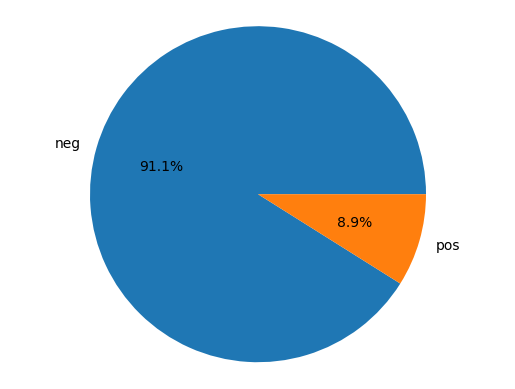

Examples:
    Total: 241555
    Positive: 21563 (8.93% of total)



In [17]:
neg, pos = np.bincount(train_df_labels.values)
total = neg + pos

labels = ['neg', 'pos']
contagem = [neg, pos]

fig1, ax1 = plt.subplots()
ax1.pie(contagem,
        labels=labels,
        autopct='%1.1f%%')

ax1.axis('equal')
plt.show()
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

In [18]:
BUFFER_SIZE = 10000
EPOCHS = 100
BATCH_SIZE = 2048

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

In [19]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.BatchNormalization(axis=1),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
  ])



  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=METRICS)
  return model

In [20]:
from keras import callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [21]:
unbalanced_validation_ds = tf.data.Dataset.from_tensor_slices((val_df_features.values, val_df_labels.values)).batch(BATCH_SIZE)
unbalanced_train_ds = make_ds(train_df_features.values, train_df_labels.values).batch(BATCH_SIZE)

In [22]:
model_1 = get_compiled_model()
training_history_unbalanced = model_1.fit(unbalanced_train_ds, epochs=EPOCHS,
                                          steps_per_epoch=resampled_steps_per_epoch,
                                          callbacks=[early_stopping],
                                          validation_data=unbalanced_validation_ds)

Epoch 1/100
215/215 [==============================] - 8s 20ms/step - loss: 0.6815 - tp: 21172.0000 - fp: 144718.0000 - tn: 256248.0000 - fn: 18182.0000 - accuracy: 0.6300 - precision: 0.1276 - recall: 0.5380 - auc: 0.6311 - prc: 0.1210 - val_loss: 0.6435 - val_tp: 162.0000 - val_fp: 3144.0000 - val_tn: 51897.0000 - val_fn: 5186.0000 - val_accuracy: 0.8621 - val_precision: 0.0490 - val_recall: 0.0303 - val_auc: 0.3597 - val_prc: 0.0655
Epoch 2/100
215/215 [==============================] - 2s 11ms/step - loss: 0.6155 - tp: 14819.0000 - fp: 79733.0000 - tn: 321316.0000 - fn: 24452.0000 - accuracy: 0.7634 - precision: 0.1567 - recall: 0.3774 - auc: 0.6685 - prc: 0.1403 - val_loss: 0.5930 - val_tp: 155.0000 - val_fp: 1807.0000 - val_tn: 53234.0000 - val_fn: 5193.0000 - val_accuracy: 0.8841 - val_precision: 0.0790 - val_recall: 0.0290 - val_auc: 0.3911 - val_prc: 0.0728
Epoch 3/100
215/215 [==============================] - 2s 11ms/step - loss: 0.5595 - tp: 7795.0000 - fp: 36856.0000 - tn:

# Realizando undersampling

In [23]:
pos_train_df_labels = train_df_labels[train_df_labels == 1]
pos_train_df_features = train_df_features[train_df_labels == 1]
pos_train_ds = make_ds(pos_train_df_features.values, pos_train_df_labels.values)

neg_train_df_labels = train_df_labels[train_df_labels == 0]
neg_train_df_features = train_df_features[train_df_labels == 0]
neg_train_ds = make_ds(neg_train_df_features.values, neg_train_df_labels.values)

resampled_ds = tf.data.Dataset.sample_from_datasets([pos_train_ds, neg_train_ds], weights=[0.5, 0.5], stop_on_empty_dataset=True)
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)
resampled_ds_size = pos * 2

undersampled_validation_ds =  tf.data.Dataset.from_tensor_slices((val_df_features.head(resampled_ds_size).values,
                                                                  val_df_labels.head(resampled_ds_size).values)).batch(BATCH_SIZE)

# Modelo - 2

In [24]:
model_2 = get_compiled_model()
training_history_undersampled = model_2.fit(resampled_ds,
                                            epochs=EPOCHS,
                                            steps_per_epoch=resampled_steps_per_epoch,
                                            callbacks=[early_stopping],
                                            validation_data=undersampled_validation_ds)

Epoch 1/100
215/215 [==============================] - 18s 68ms/step - loss: 0.7288 - tp: 128268.0000 - fp: 100173.0000 - tn: 175440.0000 - fn: 96828.0000 - accuracy: 0.6066 - precision: 0.5615 - recall: 0.5698 - auc: 0.6570 - prc: 0.5914 - val_loss: 0.6987 - val_tp: 2539.0000 - val_fp: 18901.0000 - val_tn: 20416.0000 - val_fn: 1270.0000 - val_accuracy: 0.5323 - val_precision: 0.1184 - val_recall: 0.6666 - val_auc: 0.6305 - val_prc: 0.1452
Epoch 2/100
215/215 [==============================] - 14s 64ms/step - loss: 0.6756 - tp: 122906.0000 - fp: 66941.0000 - tn: 153153.0000 - fn: 97320.0000 - accuracy: 0.6270 - precision: 0.6474 - recall: 0.5581 - auc: 0.6640 - prc: 0.6469 - val_loss: 0.6819 - val_tp: 2584.0000 - val_fp: 14493.0000 - val_tn: 24824.0000 - val_fn: 1225.0000 - val_accuracy: 0.6355 - val_precision: 0.1513 - val_recall: 0.6784 - val_auc: 0.6971 - val_prc: 0.1646
Epoch 3/100
215/215 [==============================] - 14s 64ms/step - loss: 0.6450 - tp: 139046.0000 - fp: 72600

# Realizando SMOTE

In [25]:
smt = SMOTE()
oversampled_train_df_features, oversampled_train_df_labels = smt.fit_resample(train_df_features, train_df_labels)

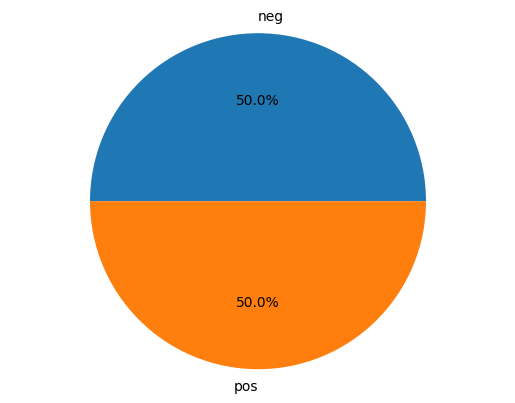

Examples:
    Total: 439984
    Positive: 219992 (50.00% of total)



In [26]:
neg_smote, pos_smote = np.bincount(oversampled_train_df_labels.values)
total_smote = neg_smote + pos_smote

labels = ['neg', 'pos']
contagem_smote = [neg_smote, pos_smote]

fig1, ax1 = plt.subplots()
ax1.pie(contagem_smote,
        labels=labels,
        autopct='%1.1f%%')

ax1.axis('equal')
plt.show()
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_smote, pos_smote, 100 * pos_smote / total_smote))

In [27]:
oversampled_train_ds = make_ds(oversampled_train_df_features.values, oversampled_train_df_labels.values).batch(BATCH_SIZE)

# Modelo 3 - SMOTE

In [28]:
model_3 = get_compiled_model()
training_history_oversampled = model_3.fit(oversampled_train_ds,
                                           epochs=EPOCHS,
                                           steps_per_epoch=resampled_steps_per_epoch,
                                           callbacks=[early_stopping],
                                           validation_data=unbalanced_validation_ds)

Epoch 1/100
215/215 [==============================] - 5s 13ms/step - loss: 0.8110 - tp: 55394.0000 - fp: 89271.0000 - tn: 170345.0000 - fn: 168436.0000 - accuracy: 0.4669 - precision: 0.3829 - recall: 0.2475 - auc: 0.5031 - prc: 0.4479 - val_loss: 0.8370 - val_tp: 4914.0000 - val_fp: 41686.0000 - val_tn: 13355.0000 - val_fn: 434.0000 - val_accuracy: 0.3025 - val_precision: 0.1055 - val_recall: 0.9188 - val_auc: 0.6381 - val_prc: 0.1236
Epoch 2/100
215/215 [==============================] - 2s 10ms/step - loss: 0.7290 - tp: 51482.0000 - fp: 44485.0000 - tn: 175814.0000 - fn: 168539.0000 - accuracy: 0.5162 - precision: 0.5365 - recall: 0.2340 - auc: 0.5438 - prc: 0.5140 - val_loss: 0.7497 - val_tp: 4847.0000 - val_fp: 35241.0000 - val_tn: 19800.0000 - val_fn: 501.0000 - val_accuracy: 0.4081 - val_precision: 0.1209 - val_recall: 0.9063 - val_auc: 0.6766 - val_prc: 0.1367
Epoch 3/100
215/215 [==============================] - 3s 13ms/step - loss: 0.7088 - tp: 80072.0000 - fp: 64962.0000 -

In [29]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Patient has no disease and wasn\'t detected (True Negatives): ', cm[0][0])
  print('Patient has no disease but was detected (False Positives): ', cm[0][1])
  print('Patient has disease but wasn\'t detected (False Negatives): ', cm[1][0])
  print('Patient has disease and was detected (True Positives): ', cm[1][1])
  print('Total patients with disease: ', np.sum(cm[1]))

In [33]:
mpl.rcParams['figure.figsize'] = (6, 5)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

# Gráfico - Desbalanceado

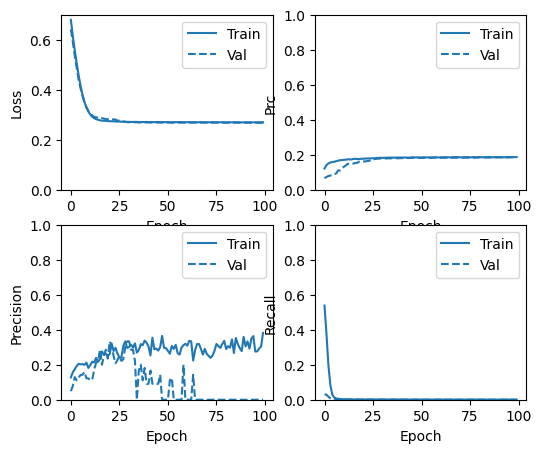

In [34]:
plot_metrics(training_history_unbalanced)

# Gráfico - Oversampled

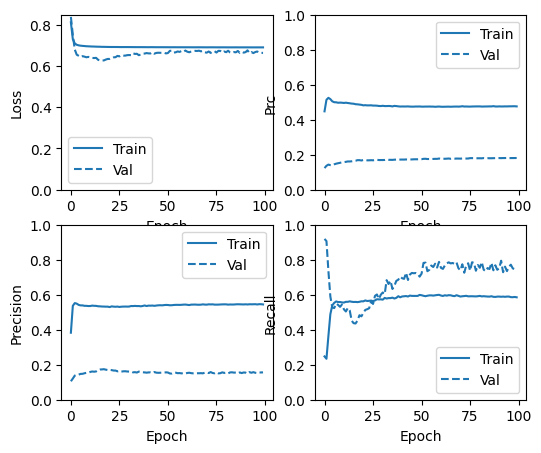

In [31]:
plot_metrics(training_history_oversampled)

# Gráfico - Underdampled

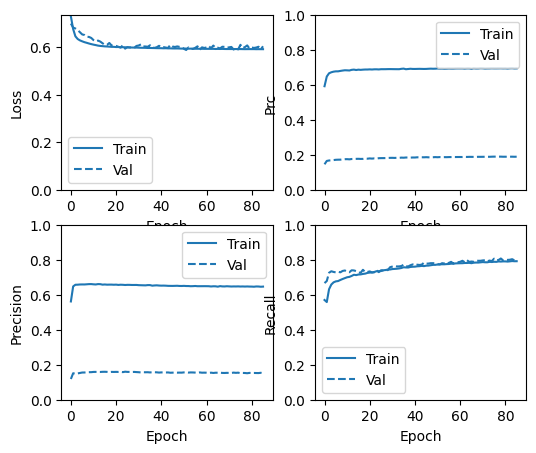

In [32]:
plot_metrics(training_history_undersampled)

In [57]:
# train_predictions_unbalanced = model_1.predict(train_df_features, batch_size=BATCH_SIZE)
test_predictions_unbalanced = model_1.predict(test_df_features, batch_size=BATCH_SIZE)

37/37 [==============================] - 0s 2ms/step


loss :  0.2724533677101135
tp :  1.0
fp :  3.0
tn :  68718.0
fn :  6765.0
accuracy :  0.9103421568870544
precision :  0.25
recall :  0.00014779780758544803
auc :  0.7327964305877686
prc :  0.18505693972110748

Patient has no disease and wasn't detected (True Negatives):  68718
Patient has no disease but was detected (False Positives):  3
Patient has disease but wasn't detected (False Negatives):  6765
Patient has disease and was detected (True Positives):  1
Total patients with disease:  6766


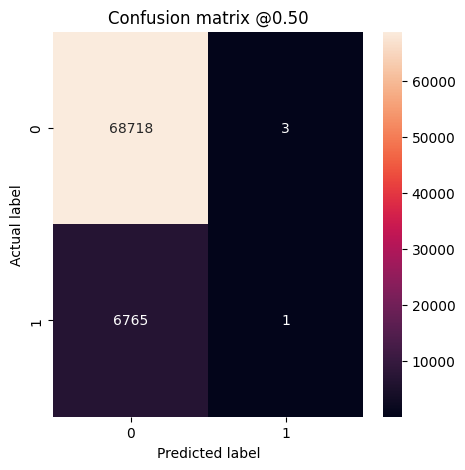

In [58]:
unbalanced_results = model_1.evaluate(test_df_features, test_df_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_1.metrics_names, unbalanced_results):
  print(name, ': ', value)
print()

plot_cm(test_df_labels, test_predictions_unbalanced)

In [59]:
# train_predictions_oversampled = model_3.predict(oversampled_train_df_features, batch_size=BATCH_SIZE)
test_predictions_oversampled = model_3.predict(test_df_features, batch_size=BATCH_SIZE)

37/37 [==============================] - 0s 2ms/step


loss :  0.6626879572868347
tp :  4925.0
fp :  26459.0
tn :  42262.0
fn :  1841.0
accuracy :  0.6251010298728943
precision :  0.15692709386348724
recall :  0.727904200553894
auc :  0.7272660732269287
prc :  0.17812718451023102

Patient has no disease and wasn't detected (True Negatives):  42262
Patient has no disease but was detected (False Positives):  26459
Patient has disease but wasn't detected (False Negatives):  1841
Patient has disease and was detected (True Positives):  4925
Total patients with disease:  6766


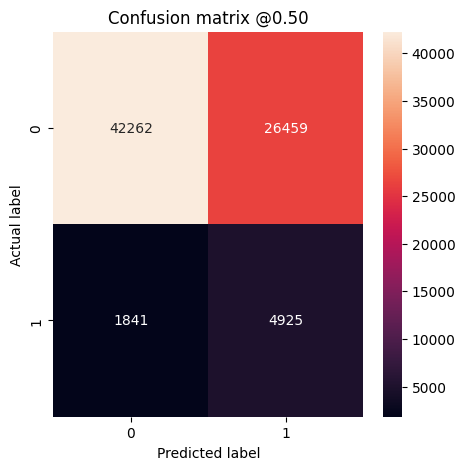

In [60]:
oversampled_results = model_3.evaluate(test_df_features, test_df_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_3.metrics_names, oversampled_results):
  print(name, ': ', value)
print()

plot_cm(test_df_labels, test_predictions_oversampled)

# Tentativa com XGBoost

In [61]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [62]:
eval_set = [(train_df_features, train_df_labels), (test_df_features, test_df_labels)]
eval_metric = ["auc","error", "pre", "aucpr"]

In [42]:
xgb_model = XGBClassifier()
xgb_model.fit(train_df_features, train_df_labels, eval_set=eval_set, eval_metric=eval_metric, verbose=True)
# make predictions for test data
y_pred = xgb_model.predict(test_df_features)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(test_df_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.73148	validation_0-error:0.08924	validation_0-pre:0.00001	validation_0-aucpr:0.17924	validation_1-auc:0.72508	validation_1-error:0.08970	validation_1-pre:0.00000	validation_1-aucpr:0.17138
[1]	validation_0-auc:0.73838	validation_0-error:0.08925	validation_0-pre:0.00001	validation_0-aucpr:0.18987	validation_1-auc:0.73141	validation_1-error:0.08968	validation_1-pre:0.00000	validation_1-aucpr:0.17990
[2]	validation_0-auc:0.74093	validation_0-error:0.08925	validation_0-pre:0.00001	validation_0-aucpr:0.19328	validation_1-auc:0.73392	validation_1-error:0.08967	validation_1-pre:0.00000	validation_1-aucpr:0.18361
[3]	validation_0-auc:0.74318	validation_0-error:0.08925	validation_0-pre:0.00001	validation_0-aucpr:0.19546	validation_1-auc:0.73610	validation_1-error:0.08967	validation_1-pre:0.00000	validation_1-aucpr:0.18619
[4]	validation_0-auc:0.74499	validation_0-error:0.08924	validation_0-pre:0.00001	validation_0-aucpr:0.19934	validation_1-auc:0.73692	validation_1-error:

In [43]:
results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

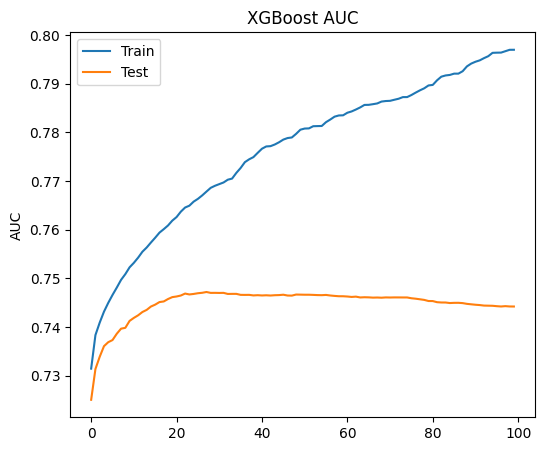

In [44]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

Patient has no disease and wasn't detected (True Negatives):  68693
Patient has no disease but was detected (False Positives):  28
Patient has disease but wasn't detected (False Negatives):  6748
Patient has disease and was detected (True Positives):  18
Total patients with disease:  6766


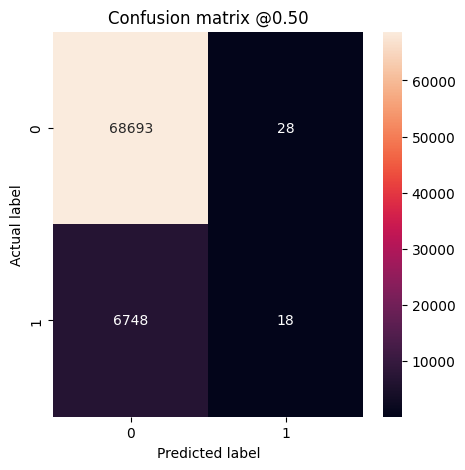

In [45]:
plot_cm(test_df_labels, y_pred)

In [46]:
smote_xgb_model = XGBClassifier()
smote_xgb_model.fit(oversampled_train_df_features, oversampled_train_df_labels, eval_set=eval_set, eval_metric=eval_metric, verbose=True)
# make predictions for test data
smote_prediction_features = smote_xgb_model.predict(test_df_features)
smote_predictions = [round(value) for value in smote_prediction_features]
# evaluate predictions
accuracy = accuracy_score(test_df_labels, smote_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.65225	validation_0-error:0.23637	validation_0-pre:0.00001	validation_0-aucpr:0.12707	validation_1-auc:0.64785	validation_1-error:0.23660	validation_1-pre:0.00000	validation_1-aucpr:0.12484
[1]	validation_0-auc:0.66353	validation_0-error:0.18841	validation_0-pre:0.00001	validation_0-aucpr:0.13237	validation_1-auc:0.65933	validation_1-error:0.18962	validation_1-pre:0.00000	validation_1-aucpr:0.13064
[2]	validation_0-auc:0.68044	validation_0-error:0.21679	validation_0-pre:0.00001	validation_0-aucpr:0.14185	validation_1-auc:0.67413	validation_1-error:0.21834	validation_1-pre:0.00000	validation_1-aucpr:0.14098
[3]	validation_0-auc:0.68773	validation_0-error:0.17573	validation_0-pre:0.00001	validation_0-aucpr:0.14636	validation_1-auc:0.68011	validation_1-error:0.17619	validation_1-pre:0.00000	validation_1-aucpr:0.14226
[4]	validation_0-auc:0.69182	validation_0-error:0.16937	validation_0-pre:0.00001	validation_0-aucpr:0.14909	validation_1-auc:0.68467	validation_1-error:

In [63]:
results = smote_xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

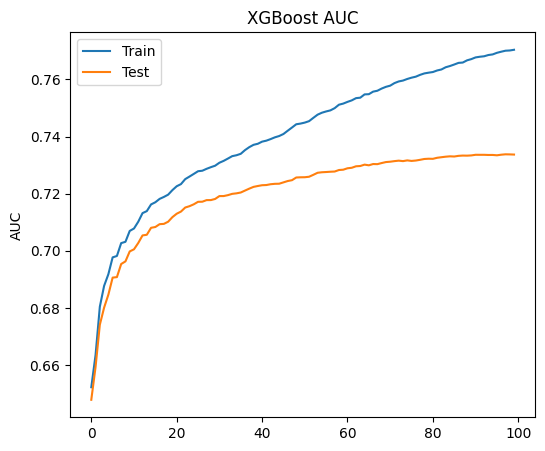

In [64]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

Patient has no disease and wasn't detected (True Negatives):  68256
Patient has no disease but was detected (False Positives):  465
Patient has disease but wasn't detected (False Negatives):  6619
Patient has disease and was detected (True Positives):  147
Total patients with disease:  6766


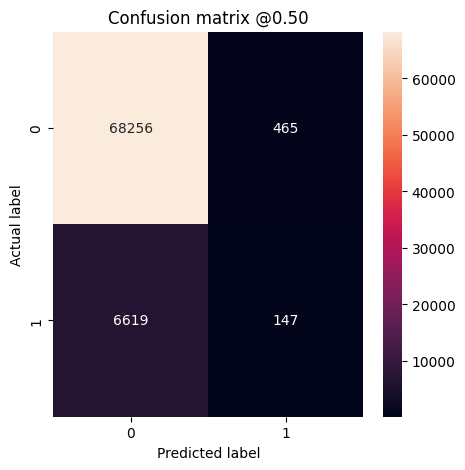

In [65]:
plot_cm(test_df_labels, smote_prediction_features)